<a href="https://colab.research.google.com/github/Mastroiani/TCC/blob/main/MLDT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>PONTIFÍCIA UNIVERSIDADE CATÓLICA DE MINAS GERAIS</h1>
<h1>PÓS-GRADUAÇÃO LATO SENSU EM CIÊNCIA DE DADOS E BIG DATA</h1>
<h1>TCC - TRABALHO DE CONCLUSÃO DE CURSO</h1>
<br>
<ul>
<h3>MODELOS SUPERVISIONADOS DE APRENDIZADO DE MÁQUINA APLICADOS À PREDIÇÃO DE INCOMPATIBILIDADE NO PREÇO DECLARADO DE MERCADORIAS IMPORTADAS
</h3>
</ul>


<h1>NOTEBOOK 2 - DESENVOLVIMENTO DOS MODELOS DE ML<h1>

# <h1>1 - Instalação de módulos e importação de bibliotecas utilizadas
<hr>
</h1>

In [2]:
!pip install plotly
!pip install graphviz
!pip install scikit-plot

In [3]:
import pandas as pd
import numpy as np

from time import time

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import Image  
import pydotplus
import pickle

import seaborn as sns
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn import metrics 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, matthews_corrcoef
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals.six import StringIO

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).



# <h1> 2 - Carregando o dataset preprocessado no objeto 'df' (dataframe)
<hr>
</h1>

In [4]:
path = '/content/drive/MyDrive'
name = 'dataset_preprocessado_TCC'

df = pd.read_csv(f'{path}/{name}')
df.shape

(1180, 38)

In [5]:
"""from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['pais_de_origem_enc'] = le.fit_transform(df['pais_de_origem'])
df['pais_de_aquisicao_enc'] = le.fit_transform(df['pais_de_aquisicao'])
df['unidade_desembaraco_enc'] = le.fit_transform(df['unidade_desembaraco'])
df['incoterm_enc'] = le.fit_transform(df['incoterm'])
df.head(2)"""
df.head(2)

,adicao,item,ano,mes,cod_ncm,descricao_do_codigo_ncm,pais,pais_de_origem,pais_1,pais_de_aquisicao,und_estat,unidade_de_medida,unidade_comerc,descricao_do_produto,qtde_estatistica,peso_liquido,vmle_dolar,vl_frete_dolar,vl_seguro_dolar,valor_un_prod_dolar,qtd_comercial,tot_un_prod_dolar,unidade_desembarque,unidade_desembaraco,incoterm,nat_informacao,situacao_do_despacho,peso_liquido_rateado,valor_frete_rateado,seguro_rateado,total_unitario_fob,fob_kg,cotacao,incompatibil,pais_de_origem_enc,pais_de_aquisicao_enc,unidade_desembaraco_enc,incoterm_enc
0,199600001,19960000100001,2020,7,72172090,"OUTS.FIOS D/FERRO OU AÇO,GALVA",827,turquia,827,turquia,10.0,QUILOGRAMA LIQUIDO,tonelada,arame galvanizado rolos diametro camada zinco ...,100486.0,100486.0,62609.85,1956.0,100.49,635.000201,49.776,31607.770000,PORTO DE RIO GRANDE,alf porto alegre,CIF,efetiva,di desembaraçada,49776.0,968.909659,49.580827,30589.279514,0.614539,0.548,0,15,15,1,1
1,199600001,19960000100002,2020,7,72172090,"OUTS.FIOS D/FERRO OU AÇO,GALVA",827,turquia,827,turquia,10.0,QUILOGRAMA LIQUIDO,tonelada,arame galvanizado rolos diametro camada zinco ...,100486.0,100486.0,62609.85,1956.0,100.49,645.000197,25.373,16365.590001,PORTO DE RIO GRANDE,alf porto alegre,CIF,efetiva,di desembaraçada,25373.0,493.895548,25.671520,15846.022934,0.624523,0.548,0,15,15,1,1


# <h1>3 - Definindo bases de treino e teste, e funções utilizadas</h1>
<hr>
<h2>Definindo variáves usadas no treinamento (X) e variável target (y)</h2>

In [6]:
X = df[['pais_de_origem_enc', 'pais_de_aquisicao_enc','unidade_desembaraco_enc', 'incoterm_enc',
       'qtde_estatistica',
       'vmle_dolar',
       'vl_frete_dolar',
       'vl_seguro_dolar',
       'valor_un_prod_dolar',
       'qtd_comercial',
       'peso_liquido_rateado',
       'valor_frete_rateado',
       'seguro_rateado',
       'total_unitario_fob',
       'fob_kg'
       ]]

y = df[['incompatibil']]

<h2>Definindo bases de treino e de teste</h2>

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y, random_state = 64)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(826, 15) (354, 15) (826, 1) (354, 1)


# <h2>Definindo funções utilizadas para desenvolvimento dos modelos</h2>


1.   mostra_confusion_matrix: plota a matriz confusão em conjunto das estatísticas de teste relacionadas (acurácia, precisão, revocação e f1 score)
2.   train_model: executa o treinamento do modelo
3.   GridSearchOptmizer: executa busca pelos melhores hiperparâmetros; realiza treinamento e cross validation com os hiperparâmetros otimizados; e defini importância das variáveis na construção do modelo.

In [8]:
def mostra_confusion_matrix(cf,
    group_names = None, categories = 'auto', count = True, percent = True, cbar = True, xyticks = False, xyplotlabels = True, sum_stats = True, figsize = (6, 6), cmap = 'Reds'):
    
    # Gera o texto dentro de cada quadrado
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

    # Gera estastísticas de teste
    if sum_stats:
        accuracy = np.trace(cf) / float(np.sum(cf))

        # caso se trate de matriz confusão binária informa estatísticas adicionais (Precisão, Revocação e F1 Score)
        if len(cf)==2:
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAcurácia={:0.4f}\nPrecisão={:0.4f}\nRevocação={:0.4f}\nF1 Score={:0.4f}".format(accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAcurácia={:0.4f}".format(accuracy)
    else:
        stats_text = ""

    # Plota o mapa de calor
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)

In [9]:
# função de treinamento do modelo
def train_model(ml):
    ml.fit(X_train, y_train)
    
    # argumentos da função 'mostra_confusion_matrix'
    cf_labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    cf_categories = [0,1]
    pred = ml.predict(X_test)
    cm = confusion_matrix(y_test, pred)
    
    #função de plotagem da matriz confusão e estatísticas de teste relacionadas ao modelo
    mostra_confusion_matrix(cm, group_names = cf_labels, categories= cf_categories)

In [10]:
def GridSearchOptimizer(ml, ml_Opt, d_hiperparametros, X_train, y_train, X_test, y_test, i_CV):
    
    # Realiza GridSearchCV em busca dos melhores hiperparâmetros
    ml_GridSearchCV = GridSearchCV(ml, d_hiperparametros, cv = i_CV, n_jobs = -1, verbose= 10, scoring = 'accuracy')
    start = time()
    ml_GridSearchCV.fit(X_train, y_train)
    tempo_elapsed = time()-start
    print(f"\nGridSearchCV levou {tempo_elapsed:.2f} segundos.")

    # Imprimi hiperparâmetros que otimizam a classificação
    print(f'\nHiperparâmetros otimizados: {ml_GridSearchCV.best_params_}')

    if ml_Opt == 'ml_DT2':
      print(f'\nDecisionTreeClassifier *********************************************************************************************************')
      ml_Opt = DecisionTreeClassifier(criterion= ml_GridSearchCV.best_params_['criterion'], 
                                    max_depth= ml_GridSearchCV.best_params_['max_depth'],
                                    max_leaf_nodes= ml_GridSearchCV.best_params_['max_leaf_nodes'],
                                    min_samples_split= ml_GridSearchCV.best_params_['min_samples_leaf'],
                                    min_samples_leaf= ml_GridSearchCV.best_params_['min_samples_split'],
                                    min_impurity_decrease= ml_GridSearchCV.best_params_['min_impurity_decrease'],
                                    random_state= 64)
    elif ml_Opt == 'ml_RF2':
        print(f'\nRandomForestClassifier *********************************************************************************************************')
        ml_Opt = RandomForestClassifier(bootstrap= ml_GridSearchCV.best_params_['bootstrap'], 
                                        max_depth= ml_GridSearchCV.best_params_['max_depth'],
                                        max_leaf_nodes= ml_GridSearchCV.best_params_['max_leaf_nodes'],
                                        criterion= ml_GridSearchCV.best_params_['criterion'],
                                        min_samples_leaf= ml_GridSearchCV.best_params_['min_samples_leaf'],
                                        min_samples_split= ml_GridSearchCV.best_params_['min_samples_split'],
                                        n_estimators= ml_GridSearchCV.best_params_['n_estimators'],
                                        random_state= 64)

    # Treina novamente usando os hiperparâmetros otimizados
    ml_Opt.fit(X_train, y_train)

    # Cross-Validation com k=10
    print(f'\n********* CROSS-VALIDATION ***********')
    ml_DT2_a_scores_CV = cross_val_score(ml_Opt, X_train, y_train, cv = 10)
    print(f'Média das Acurácias calculadas pelo CV....: {100*round(ml_DT2_a_scores_CV.mean(),4)}')
    print(f'std médio das Acurácias calculadas pelo CV: {100*round(ml_DT2_a_scores_CV.std(),4)}')
    print(ml_DT2_a_scores_CV)

    # Faz predições com os hiperparâmetros otimizados...
    y_pred = ml_Opt.predict(X_test)

    # Defini e imprimi importância das colunas (variáveis)
    print(f'\n********* IMPORTÂNCIA DAS COLUNAS ***********')
    df_importancia_variaveis = pd.DataFrame(zip(X.columns, ml_Opt.feature_importances_), columns= ['coluna', 'importancia'])
    df_importancia_variaveis = df_importancia_variaveis.sort_values(by= ['importancia'], ascending=False)
    print(df_importancia_variaveis)

    # Plotagem da matriz de confusão e estatísticas de teste
    print(f'\n********* CONFUSION MATRIX - PARAMETER TUNNING ***********')
    cf_matrix = confusion_matrix(y_test, y_pred)
    cf_labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    cf_categories = [0,1]
    mostra_confusion_matrix(cf_matrix, group_names = cf_labels, categories = cf_categories)

    return ml_Opt, ml_GridSearchCV.best_params_

# <h2>Definindo funções utilizadas para apresentação das estatísticas de treino e teste</h2>


1.   pr_curve: plota a curva precision-recall
2.   estat: apresenta as estatísticas de treino e teste, e curva precision-recall
3.   cv_import: realiza a cross-validation e apresenta a importância das variáveis para o modelo
4.   pred_comp: compara as previsões feitas pelo modelo com y_test


In [11]:
def pr_curve(ml):
  y_probas = ml.predict_proba(X_test)
  skplt.metrics.plot_precision_recall_curve(y_test, y_probas)
  plt.show()

In [12]:
def estat(ml):
  print('*********** Estatísticas da Base de Treinamento ************************\n')
  print(metrics.classification_report(y_train, ml.predict(X_train), target_names=['0','1']))

  print('*********** Estatísticas da Base de Teste ******************************\n')
  print(metrics.classification_report(y_test, ml.predict(X_test), target_names=['0','1']))

  pr_curve(ml)

In [13]:
def cv_imp(ml):
  ml_a_scores_CV = cross_val_score(ml, X_train, y_train, cv = 10)
  print(f'Média das Acurácias calculadas pelo CV....: {100*round(ml_a_scores_CV.mean(),4)}')
  print(f'std médio das Acurácias calculadas pelo CV: {100*round(ml_a_scores_CV.std(),4)}')
  print(ml_a_scores_CV)

  df_importancia_variaveis = pd.DataFrame(zip(X.columns, ml.feature_importances_), columns= ['coluna', 'importancia'])
  df_importancia_variaveis = df_importancia_variaveis.sort_values(by= ['importancia'], ascending=False)
  print('\n****************** Importância das Colunas **********************\n')
  print(df_importancia_variaveis)

In [14]:
def pred_comp(ml):
  y_pred = ml.predict(X_test)
  y_real = np.array(y_test['incompatibil'].to_list())
  print(f'Variáveis Preditas:\n {y_pred}')
  print(f'Variáveis Reais:\n {y_real}')

# <h1>4 - Modelo Máquina Suporte de Vetores</h1>
<hr></hr>

  <h10>Obs.: modelo apresentou resultado pobre quanto às estatísticas de teste (em especial revocação e f1 score)</h10>

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=64, shrinking=True, tol=0.001,
    verbose=False)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



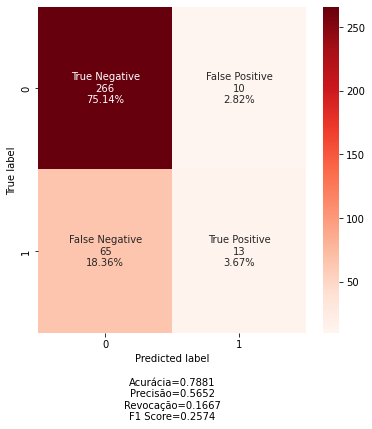

In [15]:
# instanciando modelo 'ml_SVC' de hiperparâmetros default
ml_SVC = SVC(probability=True, random_state=64)
print(ml_SVC)

# executando o treinamento do modelo
train_model(ml_SVC)

<h4>Apresentando curva precision-recall</h4>

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.



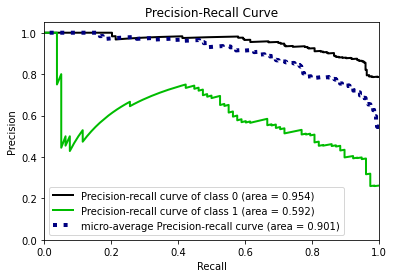

In [16]:
pr_curve(ml_SVC)

# <h1>5 - Modelo Naive Bayes</h1>
<hr></hr>

  <h10>Obs.: modelo apresentou resultado pobre quanto às estatísticas de teste (em especial precisão, revocação e f1 score)</h10>

GaussianNB(priors=None, var_smoothing=1e-09)


/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



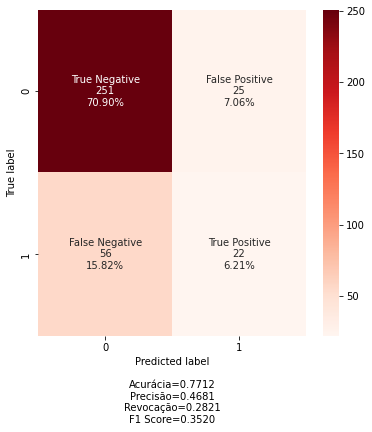

In [17]:
# instanciando modelo 'ml_SVC' de hiperparâmetros default
ml_GNB = GaussianNB()
print(ml_GNB)

# executando o treinamento do modelo
train_model(ml_GNB)

<h4>Apresentando curva precision-recall</h4>

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.



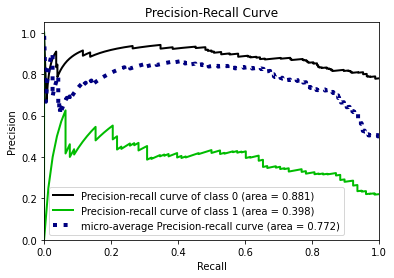

In [18]:
pr_curve(ml_GNB)

# <h1>6 - Modelo de Regressão Logística</h1>
<hr></hr>

  <h10>Obs.: modelo apresentou melhores resultados que os anteriores, porém ainda com insatisfatórias estatísticas de teste</h10>

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=64, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



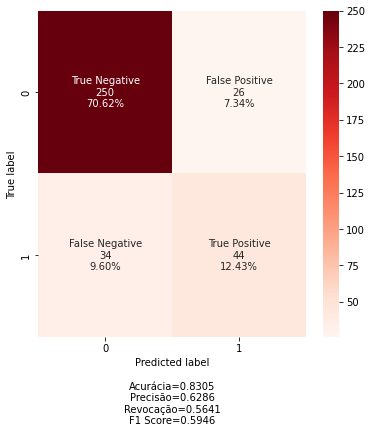

In [19]:
# instanciando modelo 'ml_SVC' de hiperparâmetros default
ml_LR = LogisticRegression(random_state=64)
print(ml_LR)

# executando o treinamento do modelo
train_model(ml_LR)

<h4>Apresentando curva precision-recall</h4>

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.



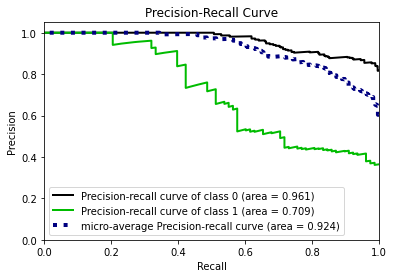

In [20]:
pr_curve(ml_LR)

# <h1>7 - Modelo de Árvore de Decisão</h1>
<hr></hr>

<h4>Realizando o treinamento com hiperparâmetros default</h4>
<h10>Obs: Modelo obteve melhor desempenho em relação aos anteriores, apresentando estatísticas de teste animadoras</h10>

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=64, splitter='best')


True

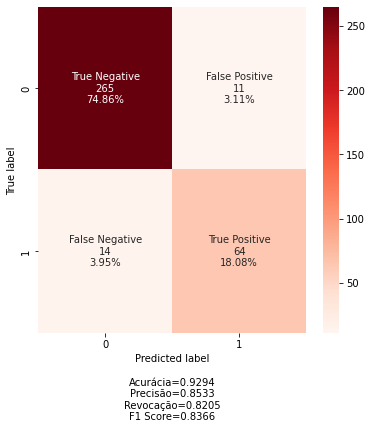

In [21]:
# instanciando modelo 'ml_DT' de hiperparâmetros default (apenas definido random_state pra efeito de reprodutibilidade das amostras)
ml_DT = DecisionTreeClassifier(random_state=64)
print(ml_DT)

# executando o treinamento do modelo
train_model(ml_DT)

# gerando e salvando a respectiva àrvore de decisão
dot_data = StringIO()
export_graphviz(ml_DT, out_file = dot_data, filled = True, rounded = True, special_characters = True, feature_names = X.columns, class_names = ['0','1'])

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('/content/drive/MyDrive/DecisionTree.png')

<h4>Apresentação das estatísticas de treino e teste, e curva precision-recall</h4>
  <h10>Nota: Verificado overfitting sobre a base de treinamento, apesar do bom resultado apresentado na base de teste</h10>

*********** Estatísticas da Base de Treinamento ************************

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       644
           1       1.00      1.00      1.00       182

    accuracy                           1.00       826
   macro avg       1.00      1.00      1.00       826
weighted avg       1.00      1.00      1.00       826

*********** Estatísticas da Base de Teste ******************************

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       276
           1       0.85      0.82      0.84        78

    accuracy                           0.93       354
   macro avg       0.90      0.89      0.90       354
weighted avg       0.93      0.93      0.93       354



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.



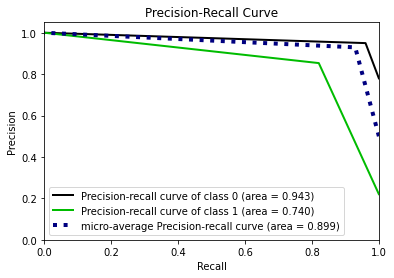

In [22]:
estat(ml_DT)

<h4>Apresentação da Árvore de Decisão</h4>
  <h10>Obs.: complexidade da árvore demonstra necessidade de ajuste de hiperparâmetros (tunning)</h10>

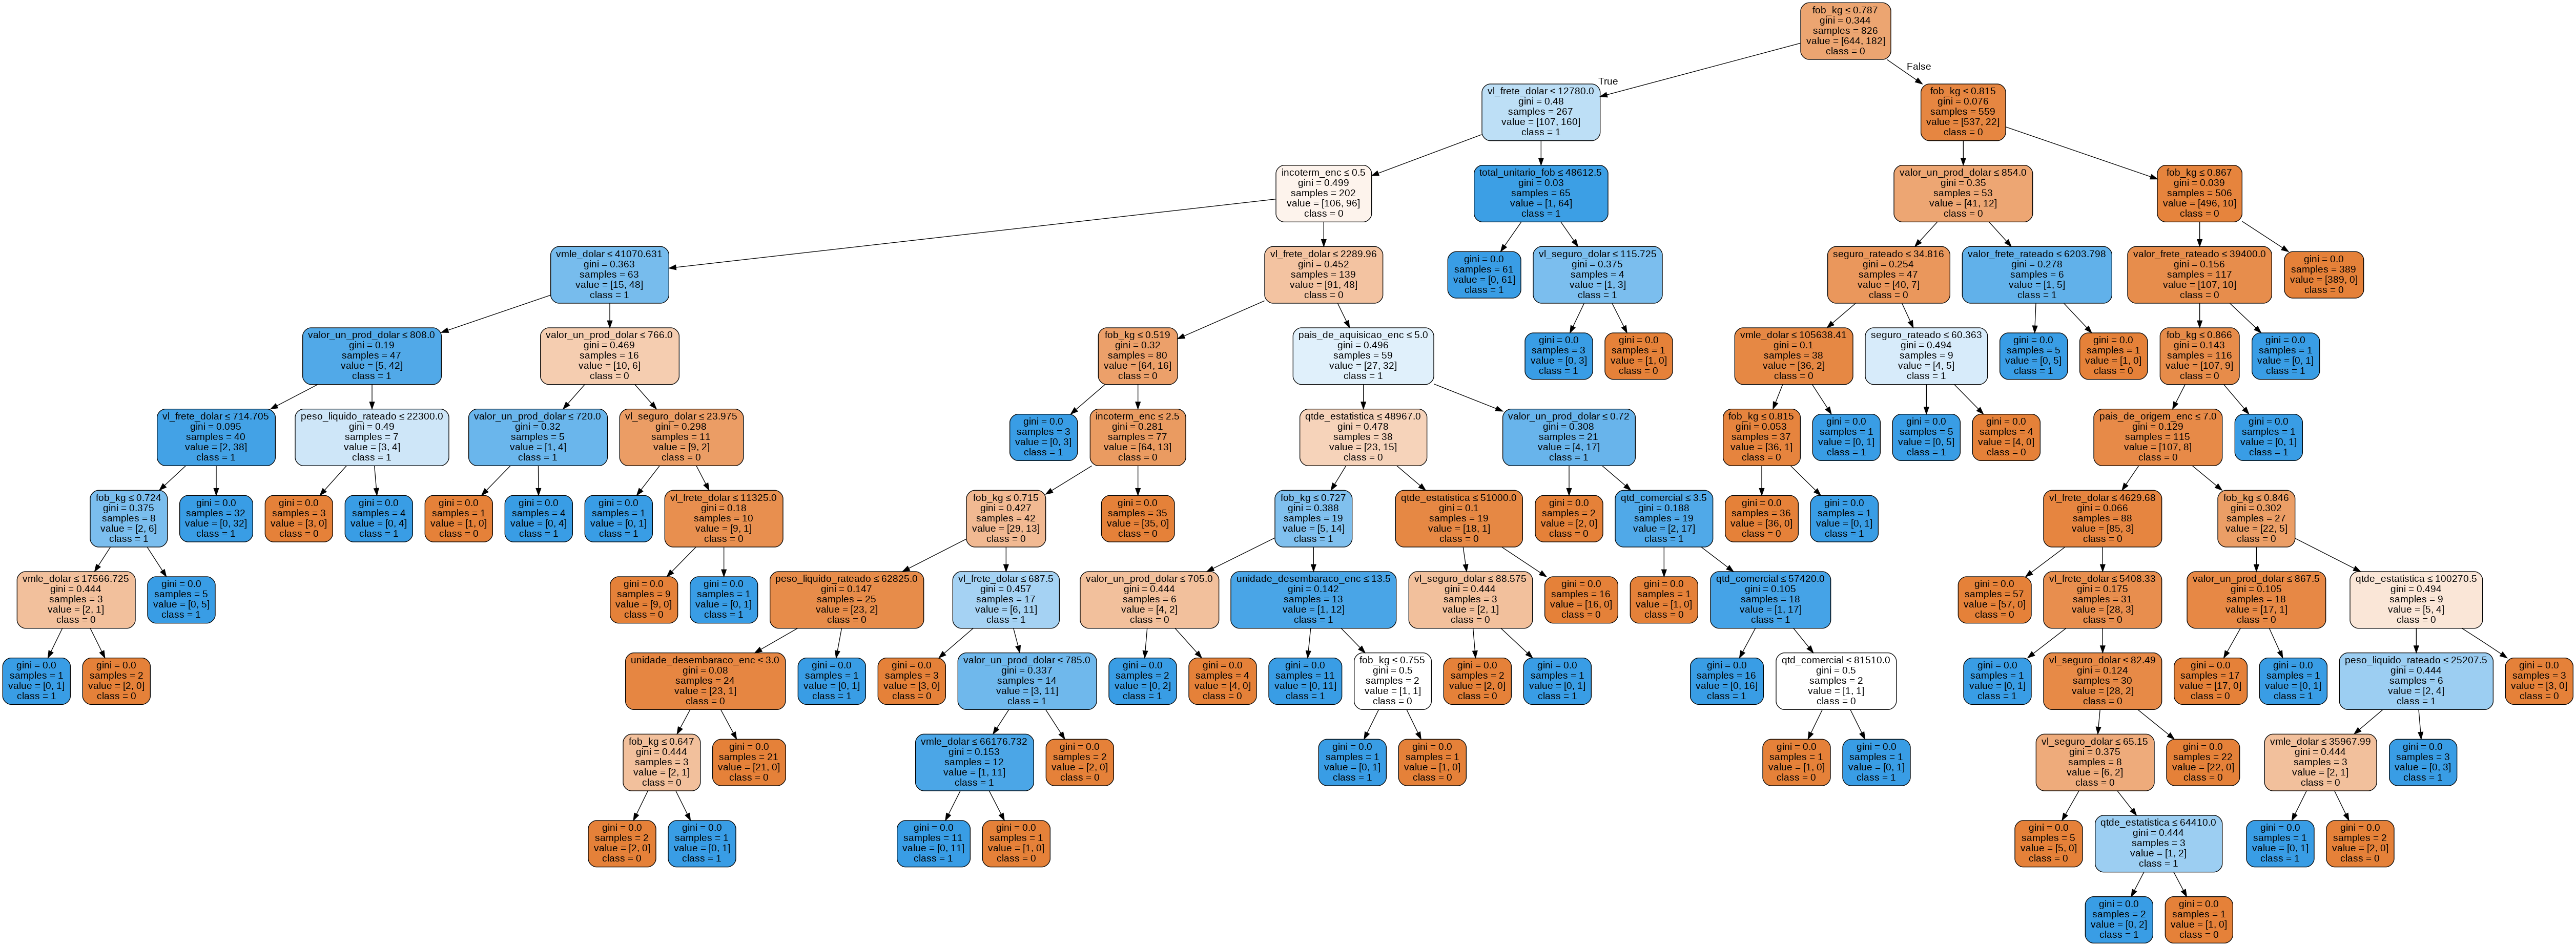

In [23]:
Image(graph.create_png())

<h4>Aplicando a Cross Validation (k=10) e verificando a importância das variáveis para o modelo</h4>

In [24]:
cv_imp(ml_DT)

Média das Acurácias calculadas pelo CV....: 91.05
std médio das Acurácias calculadas pelo CV: 3.05
[0.96385542 0.87951807 0.92771084 0.85542169 0.90361446 0.89156627
 0.91463415 0.91463415 0.95121951 0.90243902]

****************** Importância das Colunas **********************

                     coluna  importancia
14                   fob_kg     0.498704
6            vl_frete_dolar     0.145144
8       valor_un_prod_dolar     0.074888
3              incoterm_enc     0.065908
5                vmle_dolar     0.044978
4          qtde_estatistica     0.044283
12           seguro_rateado     0.028631
7           vl_seguro_dolar     0.023630
10     peso_liquido_rateado     0.022993
1     pais_de_aquisicao_enc     0.016399
9             qtd_comercial     0.012611
11      valor_frete_rateado     0.011818
2   unidade_desembaraco_enc     0.005037
0        pais_de_origem_enc     0.003324
13       total_unitario_fob     0.001653


<h4>Comparando previsões com y_test</h4>
  <h10><h10>

In [25]:
pred_comp(ml_DT)

Variáveis Preditas:
 [1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1
 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0
 1 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 1 0 0 1
 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 0
 1 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 1 1 0 1]
Variáveis Reais:
 [1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1
 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1
 1 0 1 0 0 0 0 0 

<h4>Salvando o Modelo 'ml_DT'</h4>

In [26]:
file_name = '/content/drive/MyDrive/ml_DT.pkl'
pickle.dump(ml_DT, open(file_name,'wb'))

# <h2>Otimização de Hiperparâmetros</h2>
<h10>Visa diminuir overfitting e promover diminuição de complexidade da árvore com manutenção de boa capacidade preditiva e de generalização<h10>


Fitting 10 folds for each of 37632 candidates, totalling 376320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1964s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0296s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0402s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0771s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 360 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 536 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 712 t


GridSearchCV levou 2023.57 segundos.

Hiperparâmetros otimizados: {'criterion': 'entropy', 'max_depth': None, 'max_leaf_nodes': 20, 'min_impurity_decrease': 0.0005, 'min_samples_leaf': 5, 'min_samples_split': 2}

DecisionTreeClassifier *********************************************************************************************************

********* CROSS-VALIDATION ***********
Média das Acurácias calculadas pelo CV....: 91.41
std médio das Acurácias calculadas pelo CV: 3.35
[0.90361446 0.93975904 0.91566265 0.93975904 0.85542169 0.90361446
 0.8902439  0.87804878 0.93902439 0.97560976]

********* IMPORTÂNCIA DAS COLUNAS ***********
                     coluna  importancia
14                   fob_kg     0.612794
6            vl_frete_dolar     0.169922
3              incoterm_enc     0.059169
8       valor_un_prod_dolar     0.045946
11      valor_frete_rateado     0.026538
4          qtde_estatistica     0.022122
7           vl_seguro_dolar     0.020969
5                vmle_dolar   

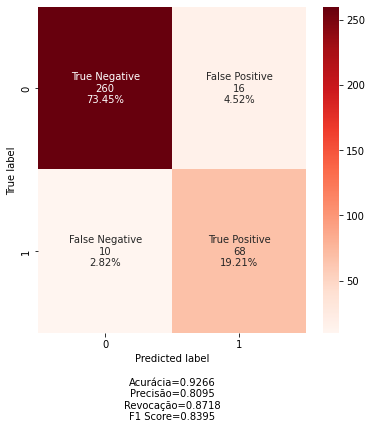

In [105]:
# Instanciando argumentos da função {criterion': 'entropy', 'max_depth': None, 'max_leaf_nodes': 15, 'min_impurity_decrease': 0.0005, 'min_samples_leaf': 15, 'min_samples_split': 2}
i_CV = 10
d_hiperparametros_DT = {"criterion": ["gini", "entropy"], 
                   "min_samples_split": [2, 3, 5, 8, 10, 15, 20], 
                   "max_depth": [None, 2, 5, 8, 10, 15], 
                   "min_samples_leaf": [1.0, 5, 8, 10, 12, 15, 20, 30], 
                   "max_leaf_nodes": [None, 2, 3, 10, 12, 15, 20, 30],
                   "min_impurity_decrease": [0.0005, 0.001, 0.0015, 0.002, 0.005, 0.01, 0.0]}
d_hiperparametros_DT

# Aplicando a função 'GridSearchOptimizer' ao modelo
ml_DT2, best_params = GridSearchOptimizer(ml_DT, 'ml_DT2', d_hiperparametros_DT, X_train, y_train, X_test, y_test, i_CV)

<h3>Apresentação da Árvore de Decisão</h3>
<h5>Considerável diminuição de complexidade da árvore ocasionada pelas restrições determinadas pelos parâmetros empregados</h5>

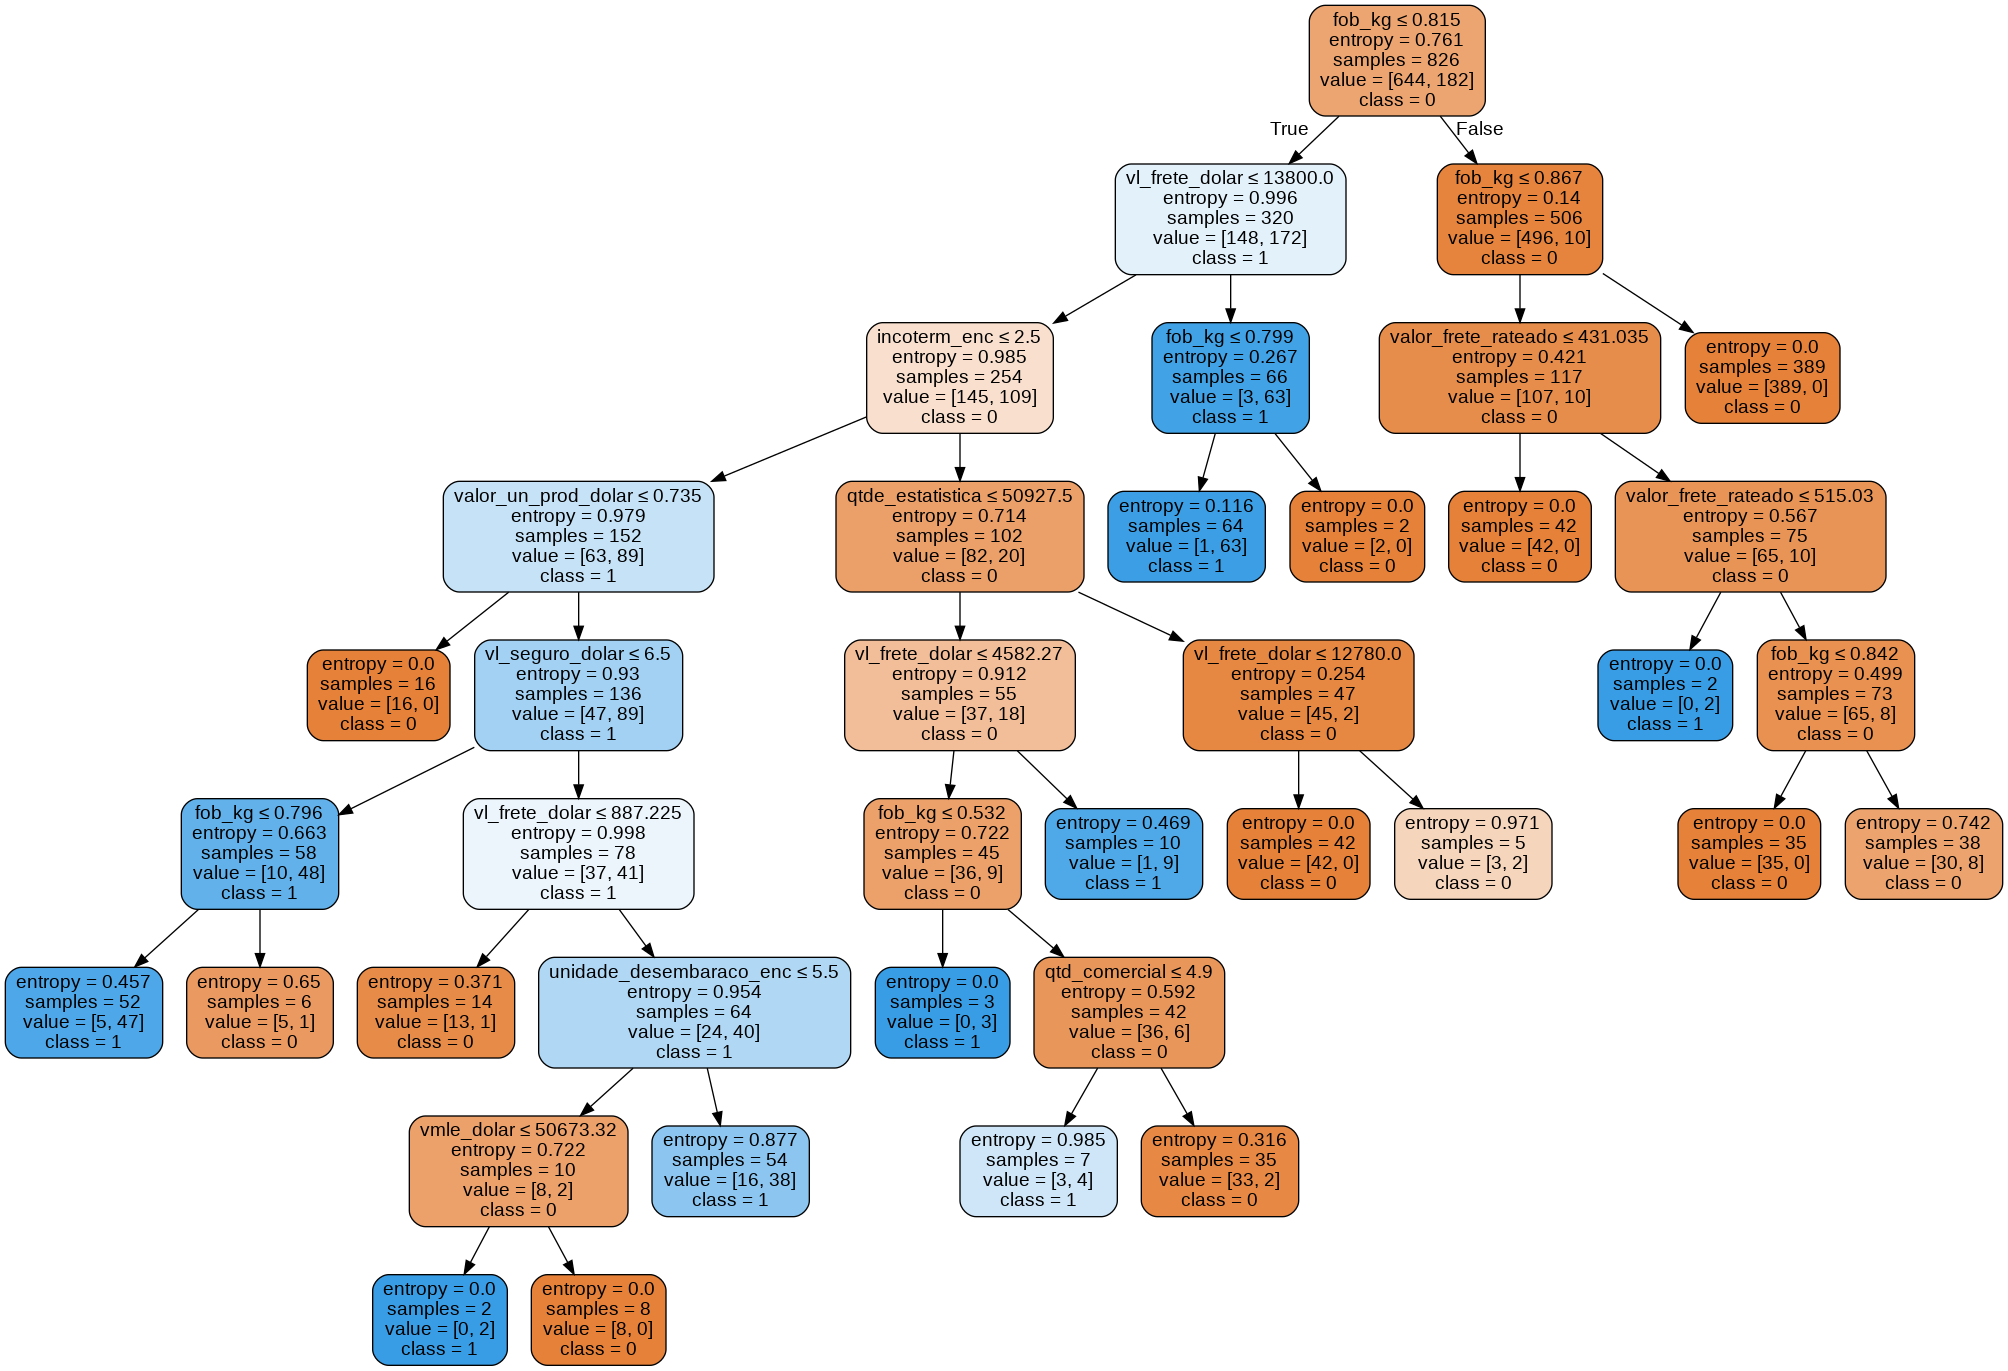

In [28]:
dot_data = StringIO()
export_graphviz(ml_DT2, out_file = dot_data, filled = True, rounded = True, special_characters = True, feature_names = X.columns, class_names = ['0','1'])

graph2 = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph2.write_png('/content/drive/MyDrive/DecisionTree2.png')
Image(graph2.create_png())

<h4>Salvando o Modelo 'ml_DT2'</h4>

In [106]:
file_name = '/content/drive/MyDrive/ml_DT2.pkl'
pickle.dump(ml_DT2, open(file_name,'wb'))

# <h2>Refazendo o treinamento com os hiperparâmetros otimizados</h2>

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=20,
                       min_impurity_decrease=0.0005, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=64, splitter='best')


True

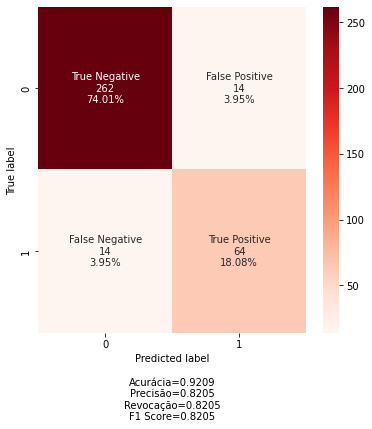

In [59]:
# Instanciando modelo 'ml_DT3' com hiperparâmetros otimizados:
# {'criterion': 'entropy', 'max_depth': None, 'max_leaf_nodes': 20, 'min_impurity_decrease': 0.0005, 'min_samples_leaf': 5, 'min_samples_split': 2}

ml_DT3 = DecisionTreeClassifier(criterion='entropy', max_depth= None, max_leaf_nodes=20, min_impurity_decrease= 0.0005, min_samples_leaf= 5, min_samples_split= 2, random_state=64)
print(ml_DT3)

# executando o treinamento do modelo
train_model(ml_DT3)

# gerando e salvando a respectiva àrvore de decisão
dot_data = StringIO()
export_graphviz(ml_DT3, out_file = dot_data, filled = True, rounded = True, special_characters = True, feature_names = X.columns, class_names = ['0','1'])

graph3 = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph3.write_png('/content/drive/MyDrive/DecisionTree3.png')

<h4>Apresentando estatísticas de treinamento e teste, e curva precision-recall</h4>
  <h10>Nota: Verificada a diminuição do overfitting sobre a base de treinamento, sendo mantido bom resultado sobre a base de teste (indicativo de boa capacidade de generalização do modelo)</h10>

*********** Estatísticas da Base de Treinamento ************************

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       644
           1       0.92      0.84      0.88       182

    accuracy                           0.95       826
   macro avg       0.94      0.91      0.92       826
weighted avg       0.95      0.95      0.95       826

*********** Estatísticas da Base de Teste ******************************

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       276
           1       0.82      0.82      0.82        78

    accuracy                           0.92       354
   macro avg       0.88      0.88      0.88       354
weighted avg       0.92      0.92      0.92       354



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.



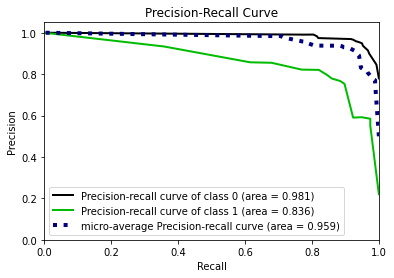

In [61]:
estat(ml_DT3)

<h4>Apresentação da Árvore de Decisão</h4>
  <h10>Obs.: notável diminuição da complexidade por meio da poda efetuada através do ajuste de hiperparâmetros</h10>

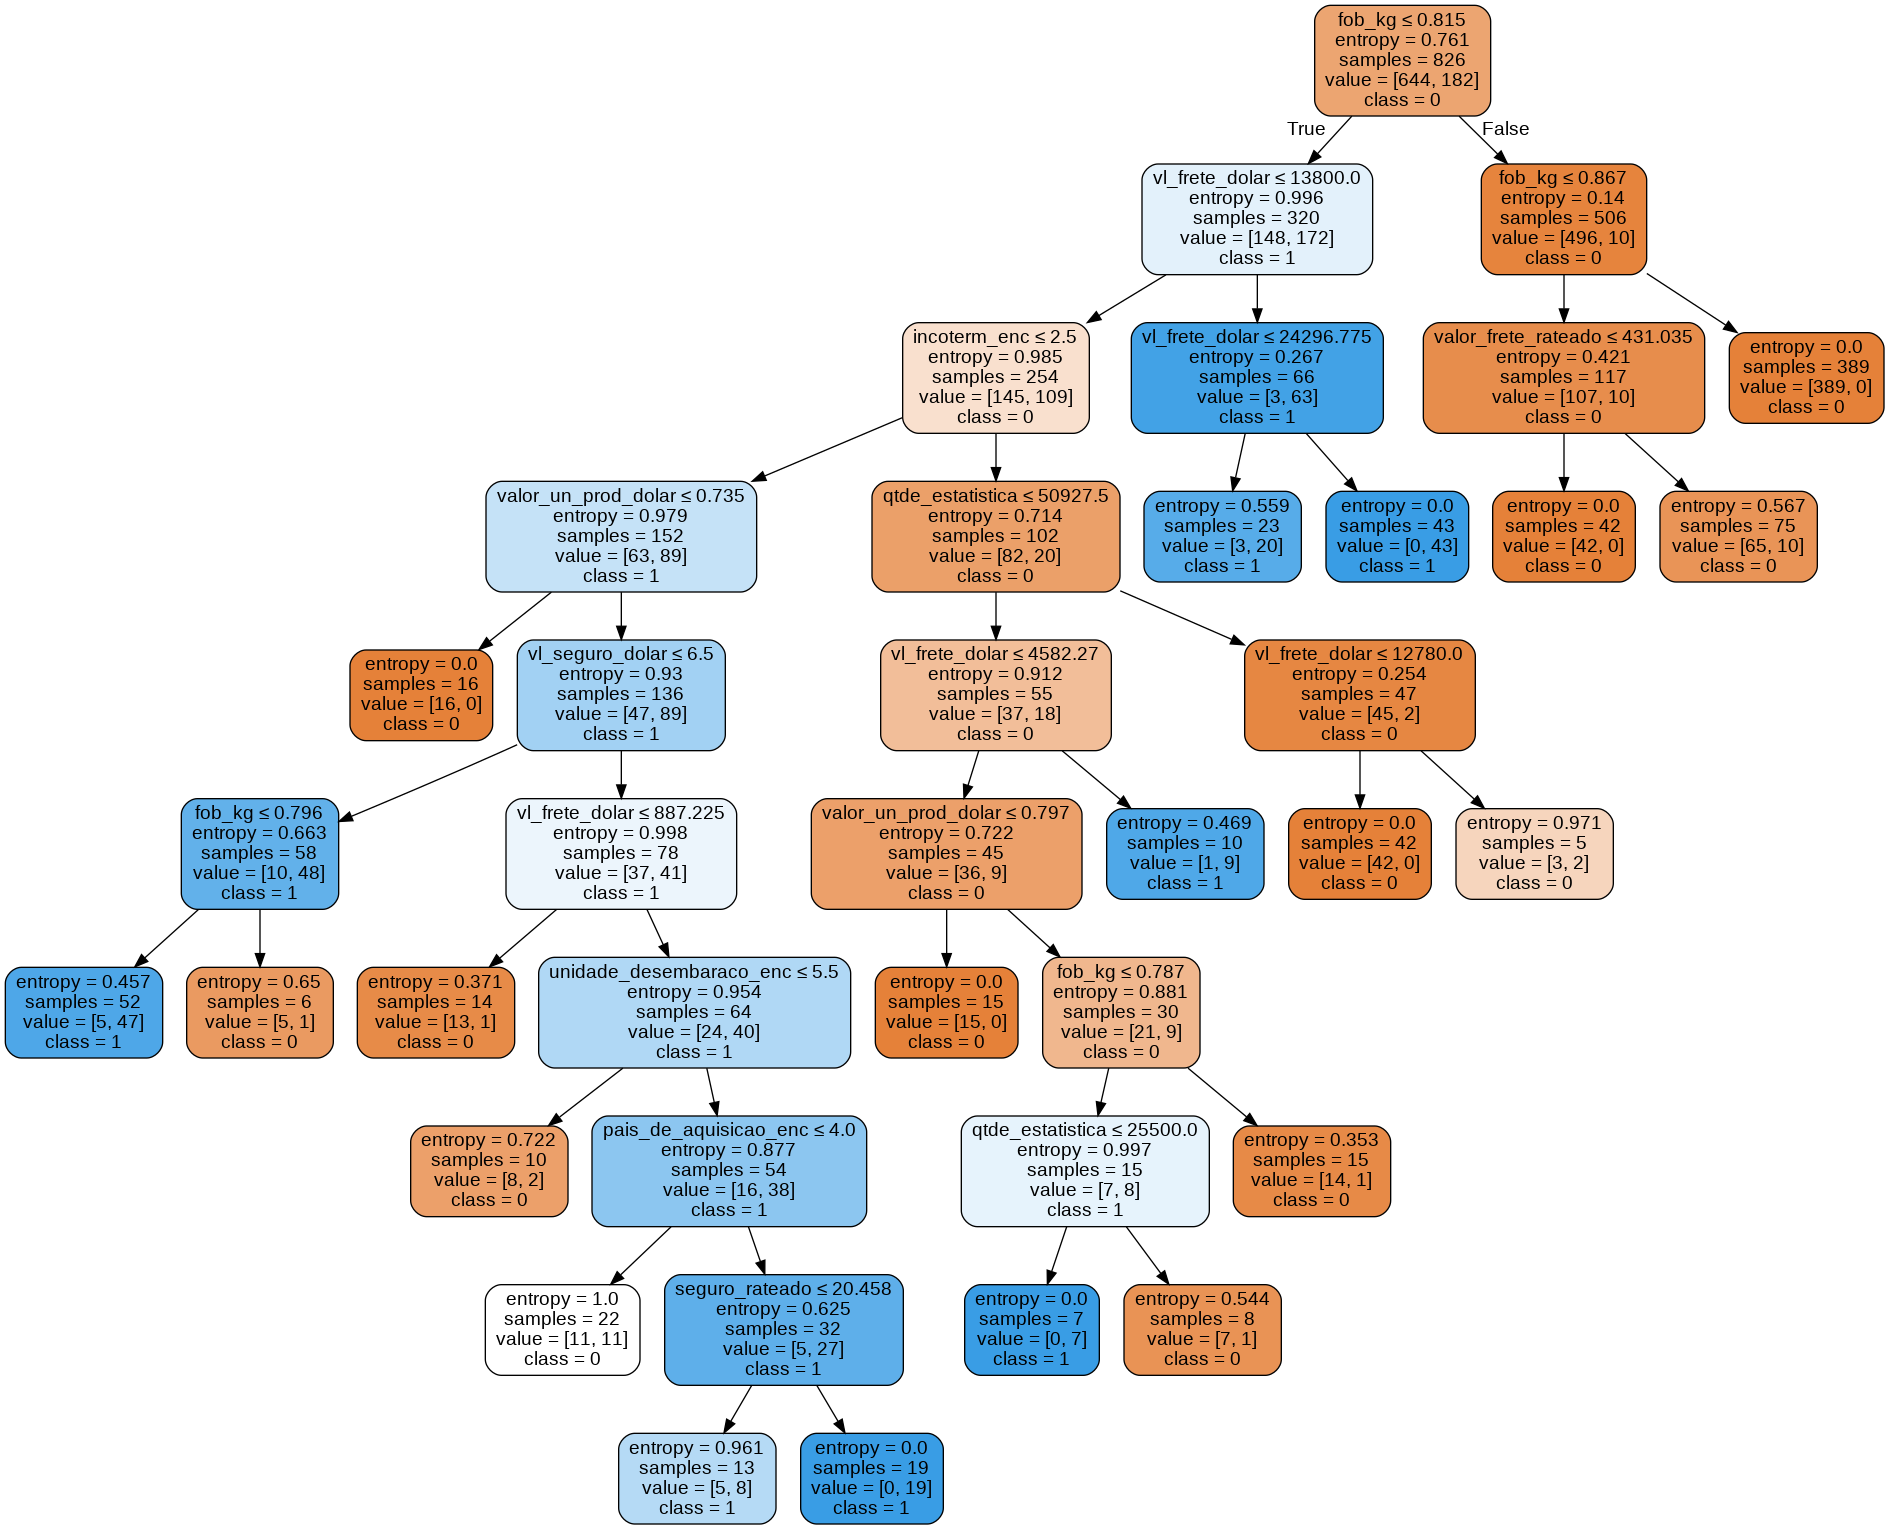

In [62]:
Image(graph3.create_png())

<h4>Aplicando a Cross Validation (k=10) e verificando a importância das variáveis para o modelo</h4>

In [63]:
cv_imp(ml_DT3)

Média das Acurácias calculadas pelo CV....: 91.64999999999999
std médio das Acurácias calculadas pelo CV: 3.6799999999999997
[0.90361446 0.93975904 0.89156627 0.93975904 0.85542169 0.91566265
 0.90243902 0.87804878 0.95121951 0.98780488]

****************** Importância das Colunas **********************

                     coluna  importancia
14                   fob_kg     0.578815
6            vl_frete_dolar     0.181889
3              incoterm_enc     0.059880
8       valor_un_prod_dolar     0.059115
4          qtde_estatistica     0.044510
7           vl_seguro_dolar     0.021221
12           seguro_rateado     0.015673
11      valor_frete_rateado     0.014162
2   unidade_desembaraco_enc     0.013606
1     pais_de_aquisicao_enc     0.011129
0        pais_de_origem_enc     0.000000
5                vmle_dolar     0.000000
9             qtd_comercial     0.000000
10     peso_liquido_rateado     0.000000
13       total_unitario_fob     0.000000


<h4>Comparando previsões com y_test</h4>
  <h10><h10>

In [64]:
pred_comp(ml_DT3)

Variáveis Preditas:
 [1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1
 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 1 0 1 1 1
 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 1 1 1 0 1 0 0 0 0 0 1 0 1 0 0 0 1
 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0
 1 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1
 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 0
 1 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0
 0 0 1 0 0 0 0 1 0 1 0 0 0 1 0 1 0 1 1 0 1]
Variáveis Reais:
 [1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1
 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1
 1 0 1 0 0 0 0 0 

<h4>Salvando o Modelo 'ml_DT3'</h4>

In [65]:
file_name = '/content/drive/MyDrive/ml_DT3.pkl'
pickle.dump(ml_DT3, open(file_name,'wb'))

# <h2>Refazendo o treinamento eliminando as variáveis consideradas irrelevantes para o modelo</h2>

In [91]:
# Redefinindo X e y
# GridSearch zero:  pais_de_origem_enc,                            peso_liquido_rateado, total_unitario_fob, seguro_rateado, pais_de_aquisicao_enc,
# Teste Hiperpar:   pais_de_origem_enc, vmle_dolar, qtd_comercial, peso_liquido_rateado, total_unitario_fob
#
# Variáveis excluídas: pais_de_origem_enc, vmle_dolar, qtd_comercial, peso_liquido_rateado, total_unitario_fob

X = df[['pais_de_aquisicao_enc','unidade_desembaraco_enc', 'incoterm_enc',
       'qtde_estatistica',
       'vl_frete_dolar',
       'vl_seguro_dolar',
       'valor_un_prod_dolar',
       'valor_frete_rateado',
       'seguro_rateado',
       'fob_kg'
       ]]

y = df[['incompatibil']]

#Redefinindo bases de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y, random_state = 64)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(826, 10) (354, 10) (826, 1) (354, 1)


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=20,
                       min_impurity_decrease=0.0005, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=64, splitter='best')


True

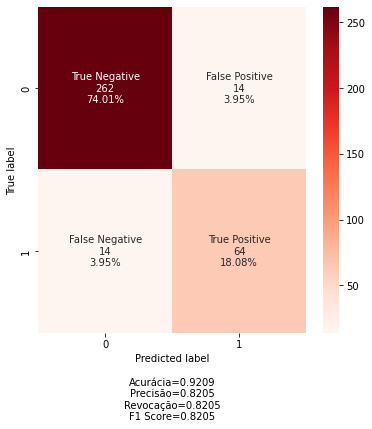

In [92]:
# instanciando modelo 'ml_DT4' com hiperparâmetros otimizados:
# # {'criterion': 'entropy', 'max_depth': None, 'max_leaf_nodes': 20, 'min_impurity_decrease': 0.0005, 'min_samples_leaf': 5, 'min_samples_split': 2}

ml_DT4 = DecisionTreeClassifier(criterion='entropy', max_depth= None, max_leaf_nodes=20, min_impurity_decrease= 0.0005, min_samples_leaf= 5, min_samples_split= 2, random_state=64)
print(ml_DT4)

# executando o treinamento do modelo
train_model(ml_DT4)

# gerando e salvando a respectiva àrvore de decisão
dot_data = StringIO()
export_graphviz(ml_DT4, out_file = dot_data, filled = True, rounded = True, special_characters = True, feature_names = X.columns, class_names = ['0','1'])

graph4 = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph4.write_png('/content/drive/MyDrive/DecisionTree4.png')

<h4>Apresentando estatísticas de treinamento e teste, e a curva precision-recall</h4>
  <h10>Nota: mantidos os resultados após eliminação das variáves irrelevantes<h10>

*********** Estatísticas da Base de Treinamento ************************

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       644
           1       0.92      0.84      0.88       182

    accuracy                           0.95       826
   macro avg       0.94      0.91      0.92       826
weighted avg       0.95      0.95      0.95       826

*********** Estatísticas da Base de Teste ******************************

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       276
           1       0.82      0.82      0.82        78

    accuracy                           0.92       354
   macro avg       0.88      0.88      0.88       354
weighted avg       0.92      0.92      0.92       354



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.



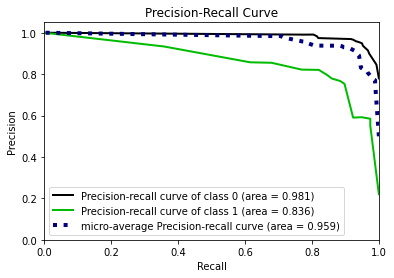

In [93]:
estat(ml_DT4)

<h4>Apresentando da Árvore de Decisão</h4>

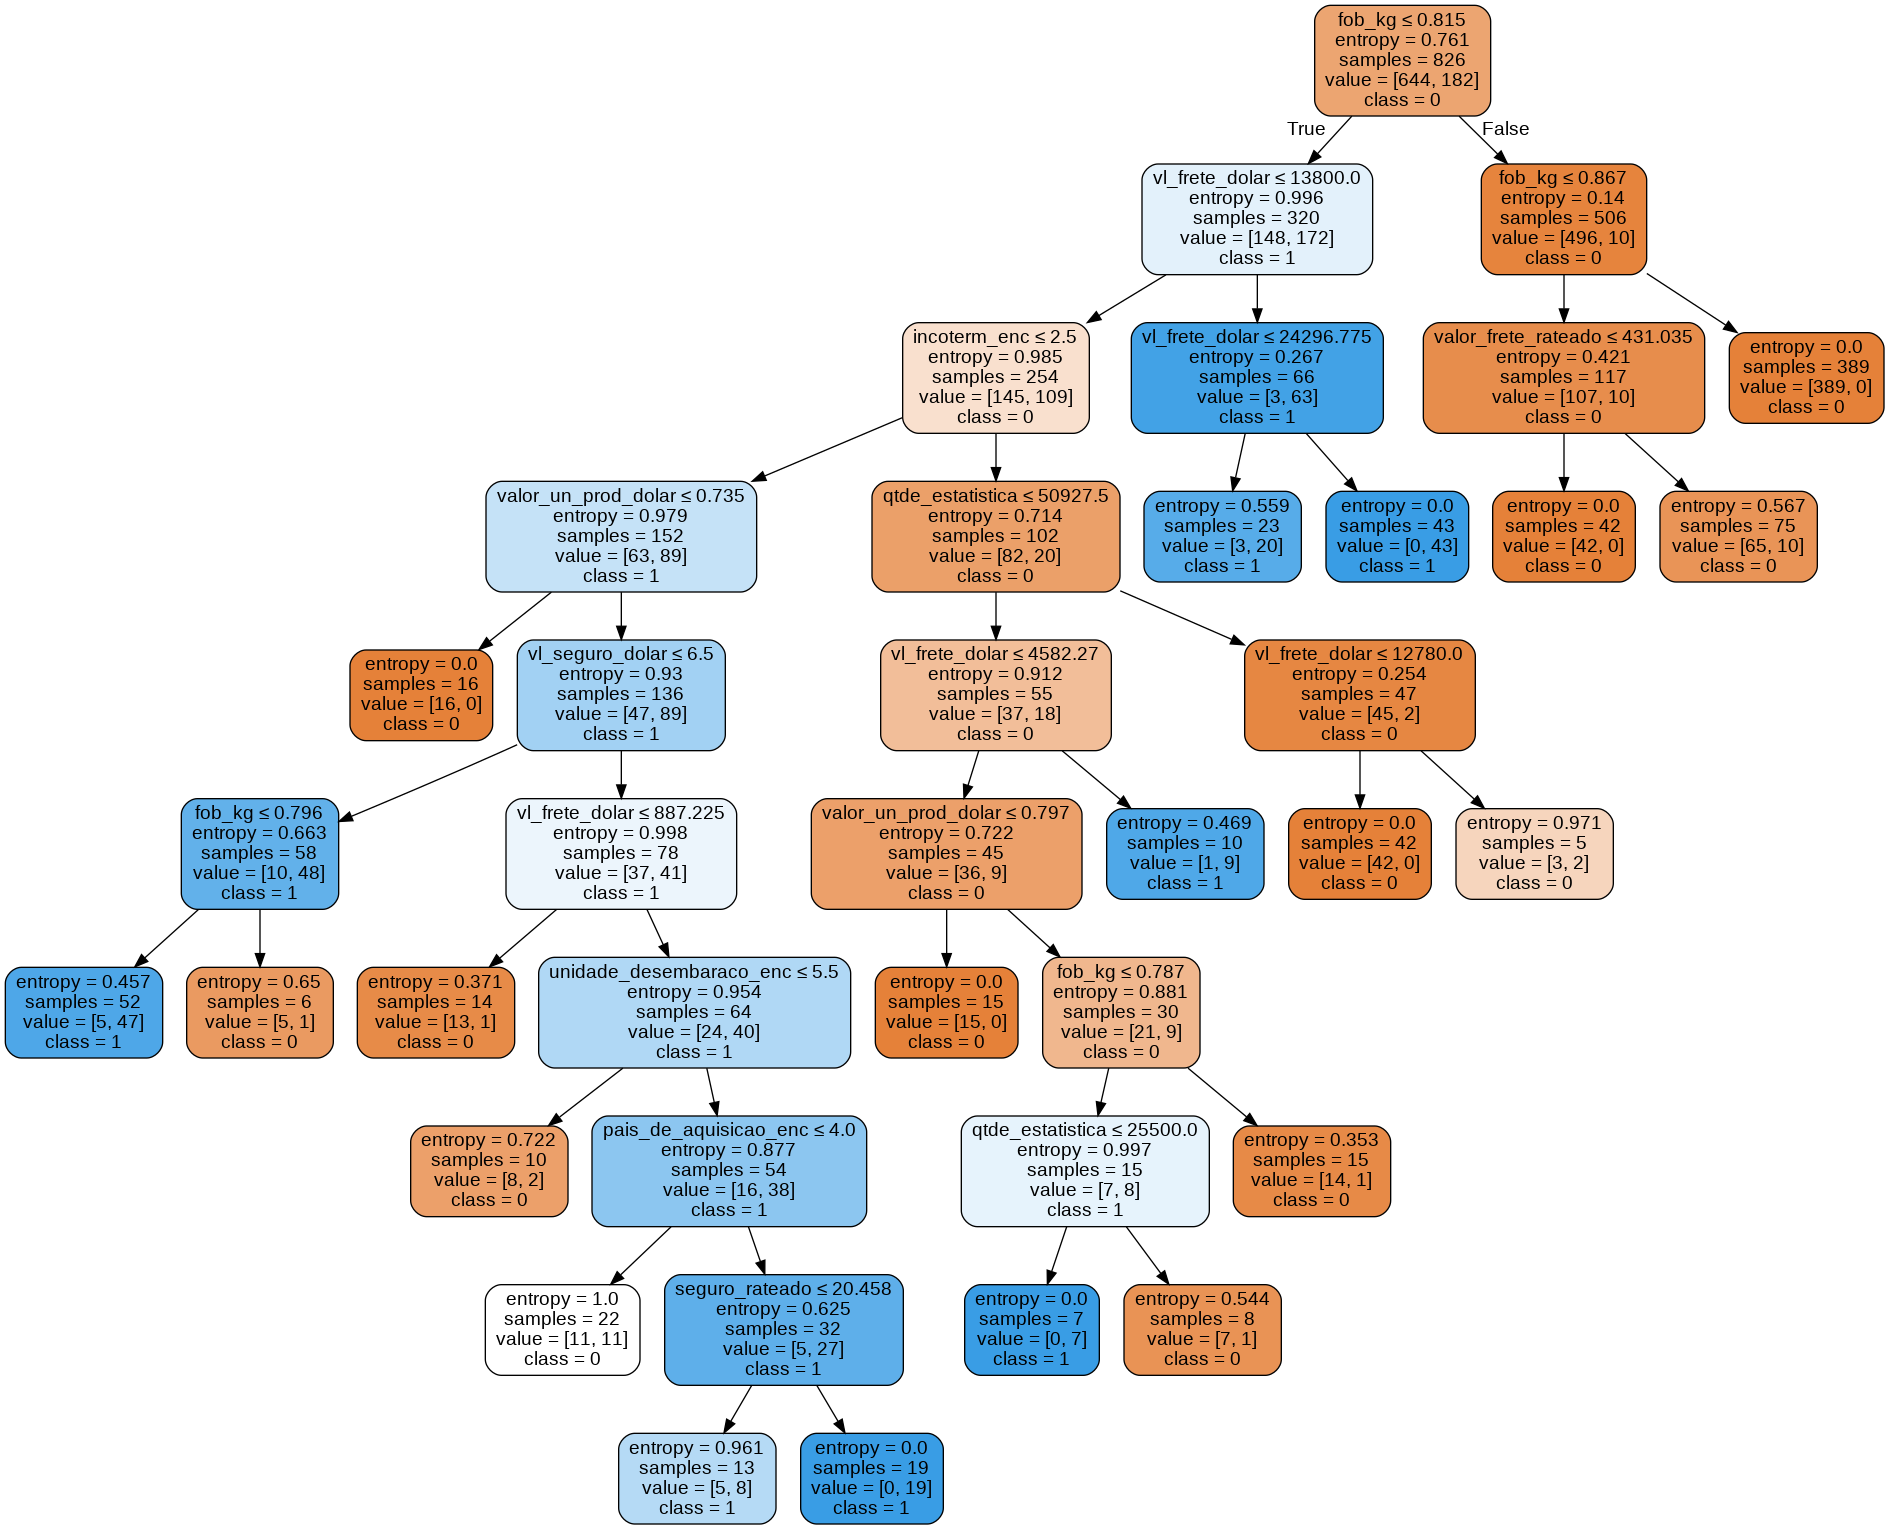

In [94]:
Image(graph4.create_png())

<h4>Aplicando a Cross Validation (k=10) e definindo a importância da variáveis pra o modelo</h4>

In [95]:
cv_imp(ml_DT4)

Média das Acurácias calculadas pelo CV....: 91.77
std médio das Acurácias calculadas pelo CV: 3.3300000000000005
[0.90361446 0.93975904 0.91566265 0.91566265 0.87951807 0.91566265
 0.90243902 0.86585366 0.95121951 0.98780488]

****************** Importância das Colunas **********************

                    coluna  importancia
9                   fob_kg     0.578815
4           vl_frete_dolar     0.181889
2             incoterm_enc     0.059880
6      valor_un_prod_dolar     0.059115
3         qtde_estatistica     0.044510
5          vl_seguro_dolar     0.021221
8           seguro_rateado     0.015673
7      valor_frete_rateado     0.014162
1  unidade_desembaraco_enc     0.013606
0    pais_de_aquisicao_enc     0.011129


<h4>Comparando previsões com y_test</h4>
  <h10><h10>

In [96]:
pred_comp(ml_DT4)

Variáveis Preditas:
 [1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1
 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 1 0 1 1 1
 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 1 1 1 0 1 0 0 0 0 0 1 0 1 0 0 0 1
 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0
 1 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1
 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 0
 1 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0
 0 0 1 0 0 0 0 1 0 1 0 0 0 1 0 1 0 1 1 0 1]
Variáveis Reais:
 [1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1
 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1
 1 0 1 0 0 0 0 0 

<h4>Salvando o Modelo 'ml_DT4'</h4>

In [97]:
file_name = '/content/drive/MyDrive/ml_DT4.pkl'
pickle.dump(ml_DT4, open(file_name,'wb'))

# <h1>8 - Modelo Floresta Randômica</h1>
<hr></hr>

<h4>Realizando o treinamento com hiperparâmetros default</h4>
<h10>Obs: Modelo obteve melhor desempenho em relação aos anteriores, apresentando estatísticas de teste animadoras</h10>

In [27]:
# Redefinindo X e y
X = df[['pais_de_origem_enc', 'pais_de_aquisicao_enc','unidade_desembaraco_enc', 'incoterm_enc',
       'qtde_estatistica',
       'vmle_dolar',
       'vl_frete_dolar',
       'vl_seguro_dolar',
       'valor_un_prod_dolar',
       'qtd_comercial',
       'peso_liquido_rateado',
       'valor_frete_rateado',
       'seguro_rateado',
       'total_unitario_fob',
       'fob_kg'
       ]]

y = df[['incompatibil']]

#Redefinindo bases de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y, random_state = 64)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(826, 15) (354, 15) (826, 1) (354, 1)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=64, verbose=0,
                       warm_start=False)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



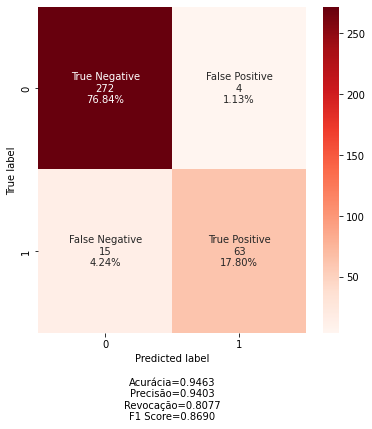

In [28]:
# instanciando modelo 'ml_RF' de hiperparâmetros default
ml_RF = RandomForestClassifier(random_state=64)
print(ml_RF)

# executando o treinamento do modelo
train_model(ml_RF)

<h4>Apresentação das estatísticas de treino e teste, e curva precision-recall</h4>
  <h10>Nota: Verificado overfitting sobre a base de treinamento, apesar do bom resultado apresentado na base de teste</h10>

*********** Estatísticas da Base de Treinamento ************************

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       644
           1       1.00      1.00      1.00       182

    accuracy                           1.00       826
   macro avg       1.00      1.00      1.00       826
weighted avg       1.00      1.00      1.00       826

*********** Estatísticas da Base de Teste ******************************

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       276
           1       0.94      0.81      0.87        78

    accuracy                           0.95       354
   macro avg       0.94      0.90      0.92       354
weighted avg       0.95      0.95      0.94       354



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.



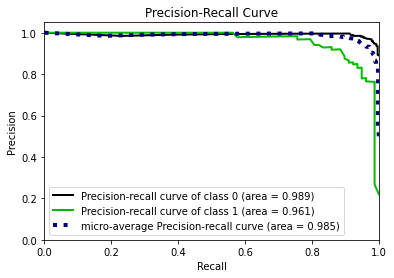

In [29]:
estat(ml_RF)

<h4>Aplicando a Cross Validation (k=10) e verificando a importância das variáveis para o modelo</h4>

In [30]:
cv_imp(ml_RF)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/s

Média das Acurácias calculadas pelo CV....: 93.10000000000001
std médio das Acurácias calculadas pelo CV: 2.18
[0.93975904 0.93975904 0.95180723 0.91566265 0.92771084 0.91566265
 0.95121951 0.87804878 0.95121951 0.93902439]

****************** Importância das Colunas **********************

                     coluna  importancia
14                   fob_kg     0.302797
8       valor_un_prod_dolar     0.114165
6            vl_frete_dolar     0.075291
11      valor_frete_rateado     0.064829
4          qtde_estatistica     0.056851
5                vmle_dolar     0.056061
13       total_unitario_fob     0.046800
7           vl_seguro_dolar     0.043510
9             qtd_comercial     0.043192
2   unidade_desembaraco_enc     0.042320
12           seguro_rateado     0.041483
3              incoterm_enc     0.037418
10     peso_liquido_rateado     0.033408
1     pais_de_aquisicao_enc     0.024823
0        pais_de_origem_enc     0.017052


<h4>Comparando previsões com y_test</h4>
  <h10><h10>

In [31]:
pred_comp(ml_RF)

Variáveis Preditas:
 [1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1
 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0
 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 1 0 0 0
 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 1 0
 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 1]
Variáveis Reais:
 [1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1
 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1
 1 0 1 0 0 0 0 0 

<h4>Salvando o Modelo 'ml_RF'</h4>

In [32]:
file_name = '/content/drive/MyDrive/ml_RF.pkl'
pickle.dump(ml_RF, open(file_name,'wb'))

# <h2>Otimização de Hiperparâmetros</h2>
<h10>Visa diminuir overfitting e promover diminuição de complexidade da árvore com manutenção de boa capacidade preditiva e de generalização<h10>


In [225]:
# Instanciando argumentos da função GridSearchOptimizer
CV = 10
d_hiperparametros_RF= {'bootstrap': [True, False],
                       'max_depth': [None, 12, 20],
                       'max_leaf_nodes': [None, 20, 30, 60],
                       'criterion': ['gini', 'entropy'],
                       'min_samples_leaf': [2, 3, 5],
                       'min_samples_split': [2, 3, 5],
                       'n_estimators': [55, 100, 300, 500]}
d_hiperparametros_RF               

{'bootstrap': [True, False],
 'criterion': ['gini', 'entropy'],
 'max_depth': [None, 12, 20],
 'max_leaf_nodes': [None, 20, 30, 60],
 'min_samples_leaf': [2, 3, 5],
 'min_samples_split': [2, 3, 5],
 'n_estimators': [55, 100, 300, 500]}

Fitting 10 folds for each of 1728 candidates, totalling 17280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:   41.2s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   50.0s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   


GridSearchCV levou 7448.13 segundos.

Hiperparâmetros otimizados: {'bootstrap': False, 'criterion': 'gini', 'max_depth': 12, 'max_leaf_nodes': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 55}

RandomForestClassifier *********************************************************************************************************

********* CROSS-VALIDATION ***********


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/s

Média das Acurácias calculadas pelo CV....: 94.07
std médio das Acurácias calculadas pelo CV: 1.7500000000000002
[0.95180723 0.95180723 0.96385542 0.91566265 0.92771084 0.92771084
 0.93902439 0.91463415 0.96341463 0.95121951]

********* IMPORTÂNCIA DAS COLUNAS ***********
                     coluna  importancia
14                   fob_kg     0.339756
8       valor_un_prod_dolar     0.126309
6            vl_frete_dolar     0.067953
5                vmle_dolar     0.059619
11      valor_frete_rateado     0.054838
4          qtde_estatistica     0.049853
7           vl_seguro_dolar     0.041496
3              incoterm_enc     0.041044
2   unidade_desembaraco_enc     0.040185
9             qtd_comercial     0.036327
13       total_unitario_fob     0.036121
12           seguro_rateado     0.032764
10     peso_liquido_rateado     0.030422
1     pais_de_aquisicao_enc     0.024862
0        pais_de_origem_enc     0.018449

********* CONFUSION MATRIX - PARAMETER TUNNING ***********


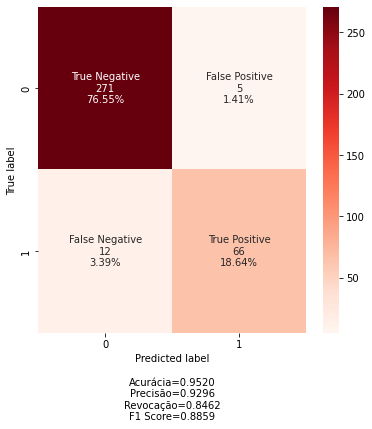

In [226]:
ml_RF2, best_params = GridSearchOptimizer(ml_RF, 'ml_RF2', d_hiperparametros_RF, X_train, y_train, X_test, y_test, i_CV)

<h4>Salvando o Modelo 'ml_RF2'</h4>

In [228]:
file_name = '/content/drive/MyDrive/ml_RF2.pkl'
pickle.dump(ml_RF2, open(file_name,'wb'))

# <h2>Refazendo o treinamento com os hiperparâmetros otimizados</h2>

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=12, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=55,
                       n_jobs=None, oob_score=False, random_state=64, verbose=0,
                       warm_start=False)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



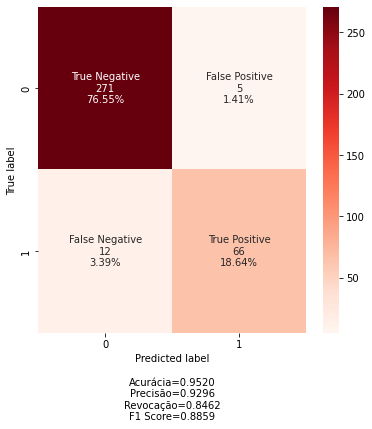

In [229]:
# instanciando modelo 'ml_Rf3' com hiperparâmetros otimizados:
# {'bootstrap': False, 'criterion': 'gini', 'max_depth': 12, 'max_leaf_nodes': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 55}

ml_RF3 = RandomForestClassifier(bootstrap = False, criterion='gini', max_leaf_nodes = None, max_depth= 12, min_samples_leaf= 2, min_samples_split= 2, n_estimators= 55, random_state=64)
print(ml_RF3)

# executando o treinamento do modelo
train_model(ml_RF3)

<h4>Apresentando estatísticas de treinamento e teste, e curva precision-recall</h4>
  <h10>Nota: Verificada a diminuição do overfitting sobre a base de treinamento, sendo mantido bom resultado sobre a base de teste (indicativo de boa capacidade de generalização do modelo)</h10>

*********** Estatísticas da Base de Treinamento ************************

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       644
           1       1.00      0.99      1.00       182

    accuracy                           1.00       826
   macro avg       1.00      1.00      1.00       826
weighted avg       1.00      1.00      1.00       826

*********** Estatísticas da Base de Teste ******************************

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       276
           1       0.93      0.85      0.89        78

    accuracy                           0.95       354
   macro avg       0.94      0.91      0.93       354
weighted avg       0.95      0.95      0.95       354



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.



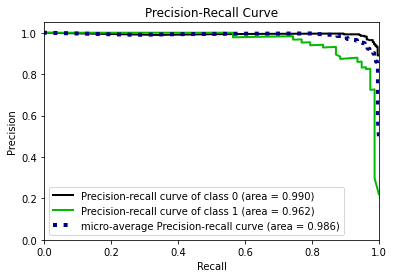

In [230]:
estat(ml_RF3)

<h4>Aplicando a Cross Validation (k=10) e verificando a importância das variáveis para o modelo</h4>

In [231]:
cv_imp(ml_RF3)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

/usr/local/lib/python3.7/dist-packages/s

Média das Acurácias calculadas pelo CV....: 94.07
std médio das Acurácias calculadas pelo CV: 1.7500000000000002
[0.95180723 0.95180723 0.96385542 0.91566265 0.92771084 0.92771084
 0.93902439 0.91463415 0.96341463 0.95121951]

****************** Importância das Colunas **********************

                     coluna  importancia
14                   fob_kg     0.339756
8       valor_un_prod_dolar     0.126309
6            vl_frete_dolar     0.067953
5                vmle_dolar     0.059619
11      valor_frete_rateado     0.054838
4          qtde_estatistica     0.049853
7           vl_seguro_dolar     0.041496
3              incoterm_enc     0.041044
2   unidade_desembaraco_enc     0.040185
9             qtd_comercial     0.036327
13       total_unitario_fob     0.036121
12           seguro_rateado     0.032764
10     peso_liquido_rateado     0.030422
1     pais_de_aquisicao_enc     0.024862
0        pais_de_origem_enc     0.018449


<h4>Comparando previsões com y_test</h4>
  <h10><h10>

In [232]:
pred_comp(ml_RF3)

Variáveis Preditas:
 [1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1
 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0 1 0 1 0 0 0 0 0 0
 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0 0 1
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 1 0
 1 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 1 0 1 1 0 1]
Variáveis Reais:
 [1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1
 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1
 1 0 1 0 0 0 0 0 

<h4>Salvando o Modelo 'ml_RF3'</h4>

In [233]:
file_name = '/content/drive/MyDrive/ml_RF3.pkl'
pickle.dump(ml_RF3, open(file_name,'wb'))

In [ ]:
mcc = matthews_corrcoef(yval, yv_pred)

# COMPARANDO OS RESULTADOS DOS MODELOS


In [62]:
models = [ml_SVC, ml_GNB, ml_LR, ml_DT, ml_RF]
models_name = ['ml_SVC', 'ml_GNB', 'ml_LR', 'ml_DT', 'ml_RF']
mcc_ls=[]
acc_ls=[]
rec_ls=[]
f1_sc_ls=[]
prec_ls=[]
results_dic = {'MCC': mcc_ls, 'Accurácia': acc_ls, 'Precisão': prec_ls, 'Revocação': rec_ls, 'F1 Score': f1_sc_ls}

for ml in models:
  y_pred = ml.predict(X_test)
  mcc = matthews_corrcoef(y_test, y_pred)
  mcc_ls.append(mcc)
  acc = accuracy_score(y_test, y_pred)
  acc_ls.append(acc)
  rec = recall_score(y_test, y_pred)
  rec_ls.append(rec)
  prec = precision_score(y_test, y_pred)
  prec_ls.append(prec)
  f1_sc = f1_score(y_test, y_pred)
  f1_sc_ls.append(f1_sc)
  

df_mcc = pd.DataFrame(results_dic, index = models_name).sort_values(by='MCC', ascending=False).round(4)
df_mcc

,MCC,Accurácia,Precisão,Revocação,F1 Score
ml_RF,0.8393,0.9463,0.9403,0.8077,0.8690
ml_DT,0.7918,0.9294,0.8533,0.8205,0.8366
ml_LR,0.4890,0.8305,0.6286,0.5641,0.5946
ml_GNB,0.2339,0.7712,0.4681,0.2821,0.3520
ml_SVC,0.2193,0.7881,0.5652,0.1667,0.2574
